# Problem Setup

## Background

I want to gain a better intuition about policy gradient based RL algorithms by analyzing it's performance when trained against a very simple environment. Given my controls background, I'm training the RL agent on a simple double-integrator system whose optimal control policy can be provided by LQR. This way, I can compare the RL agent's performance and convergence properties against the known optimal solution. 

## Problem Statement

Find control policy for an unconstrained, fully observable, discrete-time double-integrator system with quadratic cost on state and actions.

<img src="images/double_int.jpeg" alt="Alt text" width="350"/>

### Motion Model
$$
x_{t+1} 
=
A_d \cdot x_{t} + B_d \cdot u_{t}

\\=\\

\begin{bmatrix}
s_{t+1} \\
v_{t+1}
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
s_t \\
v_t
\end{bmatrix}
+
\begin{bmatrix}
\frac{1}{2 m} \Delta t^2 \\
\frac{\Delta t}{m}
\end{bmatrix}
u_{t}
$$

### Cost

$$
\min_{u} J = \sum_{t=0}^{\infty} (x_t^T \cdot Q \cdot x_t + u_t^T \cdot R \cdot u_t)
$$

such that we want to regulate the system to state of zero: $s_{desired}, v_{desired}, a_{desired} = 0$

## Comparison of Terminology

### Given

Some of the added generality with the RL setup include:
* May have partially observed state (POMDP)
* State dynamics (transition function) can be stochastic/probabilistic
* Dynamics and reward functions can be nonlinear/discontinuous and black box (no gradient information)
* Rewards can be sparse, e.g. only receiving a reward at the end of the episode.

$$
\begin{array}{c|c}
\text{Controls (LQR)} & \text{Reinforcement Learning} \\
\hline
\text{state, action} = x_t, u_t & \text{state, observation, action} = s_t, o_t, a_t,  \\
\text{state is fully observed or estimated} & \text{observation may not contain full state (POMDP)} \\
\hline
\text{cost } c(x_t, u_t) = x_t^T \cdot Q \cdot x_t + u_t^T \cdot R \cdot u_t & \text{reward } = r(s_t, a_t) \\
\hline
\text{dynamics } x_{t+1} = A_d \cdot x_{t} + B_d \cdot u_{t} & \text{Transition function } s_{t+1} \sim P(s_{t+1} \mid s_t, a_t) \\
\hline
\end{array}
$$

### Objective

RL objective is to find a policy that maximizes the expected value of the sum of discounted rewards. The expected value $\mathbb{E}$ accounts for stochastic nature of transition and policy functions.

$$
\begin{array}{c|c}
\text{Controls (LQR)} & \text{Reinforcement Learning} \\
\hline
\pi^* = \arg\min_{\pi} J = \sum_{t=0}^{\infty} (x_t^T \cdot Q \cdot x_t + u_t^T \cdot R \cdot u_t) &  \pi^* = \arg\max_{\pi} \mathbb{E}_{\tau \sim \pi} \left[ \sum_{t=0}^{T} \gamma^t r(s_t, a_t) \right]  \\
\hline
\end{array}
$$

### Result

With LQR the optimal policy is a linear function of the current state and the cost-to-go is a quadratic function of the current state.

With policy gradient based Deep RL approaches, the actions are sampled from a stochastic policy, represented by a neural net, that provides a distribution of actions given the current state. Often time the RL algorithm also captures the the value function $V(s)$ representing the expected discounted reward-to-go. 

In both cases, the cost/reward-to-go ends up being a useful tool given that both approaches utilize Bellman's Principle of optimality and Dynamic Programming methods.

$$
\begin{array}{c|c}
\text{Controls (LQR)} & \text{Reinforcement Learning} \\
\hline
u_t = -K \cdot x_t &  a_t \sim \pi_{\theta}(a_t \mid s_t)  \\
\hline
\text{cost-to-go: } J(x) = x^T \cdot P \cdot x & \text{value fn: } V(s) = V^{\pi}_{\theta}(s) \\
\hline
\end{array}
$$

# Discrete LQR Solution

Solve for P in this discrete-time Algebraic Riccati Equation:

$$
P = A^T P A - A^T P B \left( R + B^T P B \right)^{-1} B^T P A + Q
$$

The optimal control linear feedback gains can then be computed as:

$$
K = \left( R + B^T P B \right)^{-1} B^T P A
$$

Such that the optimal policy is:

$$
u_k = -K x_k
$$

And the corresponding cost-to-go is:

$$
J_k = x_k^T P x_k
$$

# Deep Reinforcement Learning (Policy Gradient)

## Visual Explanation

Policy gradient deep RL methods represent policy as deep neural network:

<img src="images/deep_rl.png" alt="Alt text" width="500"/>

At a high level, training the policy involves:
* Sampling trajectories from the environment under the current policy
* Estimate (discounted) reward-to-go for actions taken given how the episode plays out
* Update the policy to make actions that lead to good rewards more likely and actions that lead to bad rewards less likely:
  * Compute policy gradient (gradient of expected reward-to-go w.r.t. policy's neural network's parameters)
  * Take small step in direction of policy gradient

<img src="images/policy_grad_visualized.png" alt="Alt text" width="500"/>

<img src="images/rl_training_loop.png" alt="Alt text" width="400"/>

## Landscape of RL algorithms

<img src="images/rl_policies.png" alt="Alt text" width="700"/>

## Pseudocode for PPO Algorithm

1. **Initialize:**
    - Environment `Env`, policy `π(θ)`, value function `V(φ)`
    - Set learning rates `α_θ`, `α_φ`, discount factor `γ`, clipping parameter `ε`, GAE parameter `λ`
    
2. **Training loop:**
    - **for** each iteration in `range(num_iterations)`:
        - **Collect trajectories:**
            - **for** each actor in `range(num_actors)`:
                - `state = Env.reset()`, `trajectory = []`
                - **for** each step in `range(trajectory_length)`:
                    - `action = π(state | θ)`
                    - `next_state, reward, done, _ = Env.step(action)`
                    - Append `(state, action, reward, done)` to `trajectory`
                    - Update `state`, **break** if `done`
                - Append `trajectory` to `trajectories`
        
        - **Compute returns and advantages:**
            - **for** each `trajectory` in `trajectories`:
                - Calculate `returns` and `advantages` using GAE:
                    - Initialize `R = 0`
                    - **for** `t` in reversed `range(len(rewards))`:
                        - `R = rewards[t] + γ * R`
                        - `returns[t] = R`, `advantages[t] = R - V(states[t] | φ)`
            - Normalize `advantages`
        
        - **Update policy and value function:**
            - **for** _ in `range(policy_updates)`:
                - Compute `ratio = π(action | θ) / π_old(action | θ_old)`
                - Compute clipped loss: `policy_loss = -mean(min(ratio * advantages, clipped_adv))`
                - Update `θ = θ - α_θ * ∇policy_loss`
                - Compute value loss: `value_loss = mse(V(state | φ), returns)`
                - Update `φ = φ - α_φ * ∇value_loss`
        
        - Optionally update `θ_old = θ` and log metrics
    
3. **Return trained policy:** `return π(θ)`


# Training RL Agent with Stable-Baselines3

https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html

## Defining a Custom Env

Stable-Baselines3 provides implementations of a variety of RL algorithms. Thus the remaining engineering challenge becomes implementing an "environment" class that the policy can interact with.

See `double_integrator_env.py` to see the implementation of the double integrator environment.


That environment follows the basic structure of creating any custom environment, which entails deriving from `gym.Env` abstract class and implementing the abstract methods. E.g.:
```python
import gymnasium as gym
import numpy as np
from gymnasium import spaces


class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

    def step(self, action):
        ...
        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        ...
        return observation, info

    def render(self):
        ...

    def close(self):
        ...
```

## Training an RL Policy via PPO Against the Double Integrator Env

Training of the agent is done in `train_model.py`. The following is a minimal example of training against the custom `DoubleIntegratorEnv`:

In [6]:
from double_integrator_env import DoubleIntegratorEnv
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

vec_env = make_vec_env(
    DoubleIntegratorEnv,
    n_envs=1,
)

device = torch.device("cpu")

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=0,
    device=device,
    gamma=1.0,  # no discounting to make comparable with LQR
)

# Train the policy
timesteps = 10000
model.learn(
        total_timesteps=timesteps,
    )

## Loading pre-trained model

In [16]:
# load model that trained for 150000 time steps (~20hrs of sim training which takes a couple minutes running on machine)
model_name = "PPO_double_integrator"
model_steps = "150000"

vec_env = make_vec_env(DoubleIntegratorEnv, n_envs=1)

model_path = f"models/{model_name}/{model_steps}"
model = PPO.load(model_path, env=vec_env)

tensorboard can be used to visualize metrics during the training process, to check for convergence:

`tensorboard --logdir double_integrator_rl_vs_lqr`

<img src="images/tensorboard_evals.png" alt="Alt text" width="700"/>

## Running the model

The following shows minimalist example, see `eval_policy.py` for more:

In [19]:
from double_integrator_env import DoubleIntegratorEnv, State
env = DoubleIntegratorEnv()

obs, _ = env.reset(init_state=State(station = 5.0, speed=0.0))
obs_array = [obs]
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, returns, terminated, truncated, info = env.step(action)
    obs_array.append(obs)
    # env.render()
    done = terminated or truncated
    
print(f"Init state: {State(*obs_array[0])}, Final state: {State(*obs_array[-1])}")

Init state: State(station=5.0, speed=0.0), Final state: State(station=-0.105164014, speed=4.749745e-07)


### Rendering Env and Evaluating Model Performance

Comparison of RL model performance (blue) with LQR (orange), against a handful of simulated episodes with varying initial station. Left figure shows poor performance after 10,000 training steps, vs close-to-optimal (LQR) performance after 150,000 training steps.

<table>
    <tr>
        <td><img src="eval_images/PPO_double_integrator/10000.png" alt="Image 1" style="width:100%;"/></td>
        <td><img src="eval_images/PPO_double_integrator/150000.png" alt="Image 2" style="width:100%;"/></td>
    </tr>
</table>

### Introspecting the Policy

In this example I'm using the default policy network architecture with 2 hidden layers containing 64 neurons each. Below shows examples of introspecting into the policy. [See stable-baselines3 docs here](https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html) for more info on specifying custom model architectures.

In [8]:
print(model.policy)

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
# Access the first layer of the policy network
first_layer = model.policy.mlp_extractor.policy_net[0]
print(f"First layer: {first_layer}")

# Print the weights of the first layer
print(f"first layer weights: {first_layer.weight}")

First layer: Linear(in_features=2, out_features=64, bias=True)
first layer weights: Parameter containing:
tensor([[ 0.2057,  0.2936],
        [ 0.2202, -0.0627],
        [ 0.1767,  0.0925],
        [ 0.1223, -0.2022],
        [ 0.0190,  0.0274],
        [-0.2214, -0.0778],
        [ 0.3491,  0.3136],
        [ 0.1179, -0.2065],
        [-0.0693,  0.0929],
        [ 0.1432,  0.3056],
        [ 0.0834,  0.0274],
        [-0.2687,  0.3104],
        [-0.0620, -0.2876],
        [-0.1799, -0.1159],
        [ 0.0402, -0.3521],
        [ 0.0879,  0.0530],
        [-0.1200, -0.0903],
        [ 0.1208, -0.0016],
        [-0.0260, -0.1442],
        [ 0.0093, -0.2957],
        [-0.3042,  0.0740],
        [-0.1716,  0.1210],
        [-0.2364, -0.0104],
        [-0.2699,  0.3688],
        [-0.0184,  0.0177],
        [ 0.2390,  0.0218],
        [ 0.2032, -0.1881],
        [-0.1471,  0.2591],
        [ 0.0304, -0.2351],
        [ 0.0508,  0.1211],
        [ 0.0874, -0.0269],
        [-0.0573,  0.0612]

In [10]:
from torchsummary import summary

# Print a summary of the policy network
print(summary(model.policy.mlp_extractor.policy_net, input_size=(model.observation_space.shape[0],)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
              Tanh-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              Tanh-4                   [-1, 64]               0
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
None


### Visualizing Action Distribution from Policy

Normally when calling the model's policy, actions are automatically sampled from the action distribution. Below, I'm directly visualizing the action distribution to get more intuition on what it looks like and how it evolves over training.

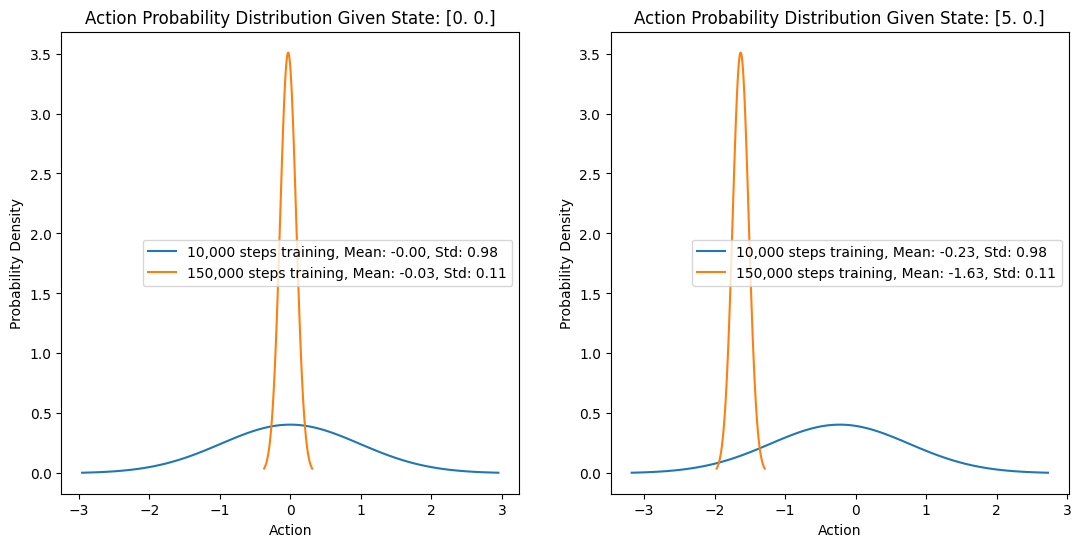

In [37]:
import numpy as np
import torch
from matplotlib import pyplot as plt


def plot_action_distribution(model, state: State, ax, label):
    # Define the state
    station, speed = 0.0, 0.0
    state = np.array([state.station, state.speed])

    # Convert the state to a tensor
    state_tensor = torch.tensor([state], dtype=torch.float32)

    # Get the action distribution from the policy
    with torch.no_grad():
        distribution = model.policy.get_distribution(state_tensor).distribution

    # Extract mean and standard deviation for the Gaussian distribution
    mean = distribution.mean.cpu().numpy().flatten()[0]
    std = distribution.variance.sqrt().cpu().numpy().flatten()[0]

    # Generate a range of possible actions
    actions = np.linspace(mean - 3 * std, mean + 3 * std, 100)

    # Calculate the probability density of each action
    probabilities = np.exp(-0.5 * ((actions - mean) ** 2) / (std ** 2)) / (std * np.sqrt(2 * np.pi))

    # Plot the distribution
    ax.plot(actions, probabilities, label=f'{label}, Mean: {mean:.2f}, Std: {std:.2f}')
    ax.set_title(f"Action Probability Distribution Given State: {state}")
    ax.set_xlabel("Action")
    ax.set_ylabel("Probability Density")
    ax.legend()
    
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

# Load mostly untrained model
model_path = f"models/PPO_double_integrator/10000"
model = PPO.load(model_path, env=vec_env)

plot_action_distribution(model, State(station=0.0, speed=0.0), axs[0], label="10,000 steps training")
plot_action_distribution(model, State(station=5.0, speed=0.0), axs[1], label="10,000 steps training")

# load fully trained model
model_path = f"models/PPO_double_integrator/150000"
model = PPO.load(model_path, env=vec_env)

plot_action_distribution(model, State(station=0.0, speed=0.0), axs[0], label="150,000 steps training")
plot_action_distribution(model, State(station=5.0, speed=0.0), axs[1], label="150,000 steps training")

plt.show()

## Comparing Value Function Network

The trained PPO policy contains both a learned policy network and value network estimated the reward-to-go. This reward-to-go estimate can also be compared to the LQR's value function (which is a quadratic function of state) as another indicator of whether the model is generalizing/converging close to the optimal solution. The figure below, generated by `eval_value_fn.png` shows that the value function network closely approximates the LQR's optimal value function.

<img src="images/value_fn_comparison.png" alt="Alt text" width="900"/>